For my first experiment with Keras, I followed the tutorial available here:
    
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

I skipped the first step of a relatively shallow network and skipped right to the part where a real CNN network was used.

Goals for learning:
- Actually see code in action.
- Get a sense for how long training takes in a virtualized setup.

I will be running this tutorial on my bare-metal setup as well to get a comparison on performance.

My next goal is to somehow obtain a ResNet50 model and run that with the fish data.

General thoughts: 

I still think that finding the fish first would be helpful, but in my discussions with Tong, he said that other people tried that and the effectiveness of just detecting a fish in the image is 80%. So whatever is done afterwards has a ceiling of 80%. I am not sure how that's done. But HOG or HARR seems to not cut it. At least for my limited trials with HOG+SVM and a sliding window, success is rather low for fish (it's actually great for faces).

Ideally, we want this: We want an automated "object" recognizer that can even be noisy as long as it provides a crop of the original picture. Ideally, we want interactive learning, where the learning algorithm presents an image, and we tell it what it is during the training. 

Using TensorFlow backend.


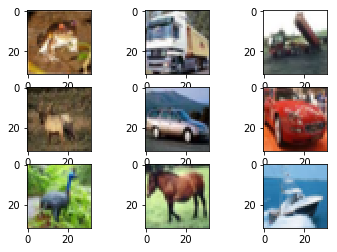

In [1]:
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(toimage(X_train[i]))
# show the plot
pyplot.show()

In [2]:
# Simple CNN model for CIFAR-10
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [3]:
seed = 7
numpy.random.seed(seed)

In [4]:
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [10]:
# Create the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), activation='relu', border_mode='same'))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(Dropout(0.2))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(Dropout(0.2))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 32, 32, 32)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 32, 32)    9248        dropout_3[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_4[0][0]            
___________________________________________________________________________________________

In [11]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 1595s - loss: 1.8472 - acc: 0.3184 - val_loss: 1.4723 - val_acc: 0.4658